# Refilling the Mediterranean (Zanclean megaflood)

### Methods adapted from:
Garcia-Castellanos, D., Estrada, F., Jiménez-Munt, I., Gorini, C., Fernàndez, M., Vergés, J. and De Vicente, R., 2009. Catastrophic flood of the Mediterranean after the Messinian salinity crisis. Nature, 462(7274), pp.778-781.


See Methods, Garcia-Castellanos et al.,(2009) for a detailed description.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd

## Setting parameters

We assume the drawdown in the western Mediterranean (wMed) to be 1750 m, and in eastern Mediterranean (eMed) to be 2000 m.

This model computes the incision at the Strait of Gibraltar in order to calculate the flood discharge and velocity.
We have calibrated ${k_b}$ (Shear stress law constant) to be $1.8*10^{-4}$ m$yr^{-1}Pa^{-a}$ to obtain a sill incision depth of 240 m at flood termination.
${k_w}$ (Channel width coefficient) is set to 1.1 to erode the channel to 14 km at flood termination.

In [26]:
D_sill = 35      # Starting sill depth [m]
Z0 = 0           # Atlantic level [m]
DMar = 1027      # Seawater density [kg m^-3]
g = 9.81         # Acceleration due to gravity [m s^-2]
Kb = 1.8*10**-4  # Shear stress law constant [m yr^-1 Pa^-a]
L = 100000       # Length of the erosive channel [m]
H = 1000         # Head loss - set to 1000 m which is equal to present Alboran Sea depth
S = H/L
a = 1.5          # Shear stress power law exponent 
t = 1            # Starting time [days]
SL_wMed = 1750   # Late Messinian drawdown in wMed [m]
SL_eMed = 2000   # Late Messinian drawdown in eMed [m]
n = 0.05

Kw = 1.1         # Channel width coefficient [m^-1/2 s^1/2]
Aw = 0.5         # empirically determined constant
Wsill = 100      # Starting sill width [m]

# Arrays used for plotting parameters
Ar_SWd = [100]    # Stores sill width
Ar_t   = [0]      # Stores time
Ar_VwM = [0]      # Stores flow velocity entering wMed 
Ar_dis = [0]      # Stores flood discharge
Ar_eR  = [0]      # Stores rate of erosion
Ar_SLw = [1750]  # Stores rise of sealevel in wMed
Ar_KEw = [0]      # Stores flow energy in wMed


# Arrays used to calculate correct sea level
x0=[0]
y0=[0]

#Volumes
Vbrine = 236.1953363  # Initial volume of the brine in WMed : Obtained from hypsometry
Vbrine2 = 590.1264956 # Initial volume of the brine in EMed : Obtained from hypsometry
Vbrine3 = 2797.703632 # Total volume of the brine at the level of Sicily sill: Obtained from hypsometry


## <span style='color:Red'> Equations  </span>

Garcia-Castellanos et al., (2009)  model computes the incision rate $(dz_{s}/dt)$ at Camarinal sill based on the following approach

Incision rate at the sill: $$\frac{dz_{s}}{dt} = {k_b(\tau_b)}^{a}$$

where $dt$ is the timestep and $dz_s$ is the depth of erosion per timestep. $k_b$ and $a=1.5$ are positive constants.

$\tau_b$ (basal shear stress at the sill) can be calculated using: $${\tau_b} = {\rho_s(g)(z_s-z_0)S} $$

where $ρ_s$ is seawater density, $(z_s-z_0)$ is the mean water depth at the sill, $g$ is acceleration due to gravity, and $S = z_h/L$ is the ratio between head loss $(z_h)$ and length of the erosive channel $(L)$. 

Manning’s formula is used to calculate the flow velocity$(v)$ entering the wMed: $$ v = \frac{1}{n}(R_h)^{(2/3)}S^{1/2}$$

where $n = 0.05$ is the roughness coefficient and $R_h$ is the hydraulic radius of the passage between the Atlantic and the Mediterranean. Where channel width is substantially greater than the depth, the hydraulic radius is approximated by $(z_s-z_0)$. 

Flood discharge is then calculated using:$$Q = W(z_s-z_0)v$$

where $a_w = 0.5$ is a constant, and we impose $k_w = 1.1$ to obtain the final channel width (14 km)

Here, $W$ is the width of the incision channel, updated per timestep using: $$W = k_w(Q^{(a_w)})$$

To approximate the minimum velocity entering the eMed during stage 2, we use present dimensions of the Noto canyon upper erosive channel (4 km width, 400 m depth).  

In [27]:
# Defines a function to calculate common parameters for each flood stage
def Calc_common_parameters(Wsill,Z0,DMar,g,D_sill,Slope,Kb,a):
    AreaSill = Wsill * D_sill                    # Sill area                  
    Rh = D_sill - Z0                             # Hydraulic radius
    v_wMed = (1/n)*(Rh**(2/3))*(Slope**(0.5))    # wMed flow velocity
    Q = v_wMed*AreaSill                          # Discharge 
    Shear = DMar*g*D_sill*Slope                  # Basal shear stress
    Erate = Kb*(Shear**a)                        # Rate of erosion
    Qd = Q*3600*24/10**12                        # Daily discharge
    return [AreaSill, Rh, v_wMed, Q, Shear, Erate, Qd]

In [28]:
# A function to append results into arrays for plotting
def append_parameters(Wsill,t,v_wMed,Q,Erate,SL_wMed,KEwMed):
        Ar_SWd.append(Wsill)
        Ar_t.append(t)
        Ar_VwM.append(v_wMed)
        Ar_dis.append(Q)
        Ar_eR.append(Erate/365)
        Ar_SLw.append(SL_wMed)
        Ar_KEw.append(KEwMed)
        return[Ar_SWd,Ar_t,Ar_VwM,Ar_dis,Ar_eR,Ar_SLw,Ar_KEw]

## Calculation of true sea-level

Reconstructed Mediterranean hypsometry gives us change in basin area per every meter.

Consider the following example.
<img src="https://www.dropbox.com/s/ek6equgnykmiulz/Correct_Sealevel.jpg?dl=1" width="606.9" height="219.8" >

Assume that the given basin was filled upto layer 3 ($L_3$) in day 1. During day 2, a volume of ($Q_D$) is added by inflow, raising the basin level.

Hypsometry can be used to get the closest volume to Day 2 basin volume, which is the cumulative volume at top of layer 4 ($L_4$)

The error in volume = $V_2$ - $V_{Cululative(L4)}$

Therefore error in sea-level rise = $\frac {V_2 - V_{Cululative(L4)}}{A_5}$

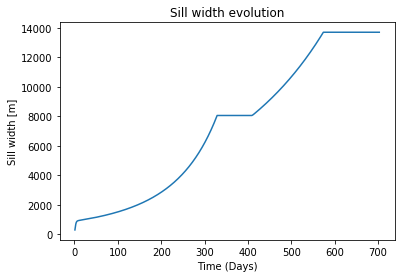

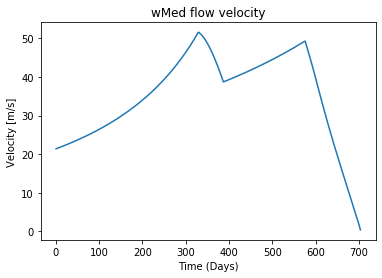

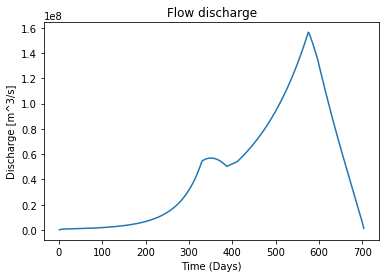

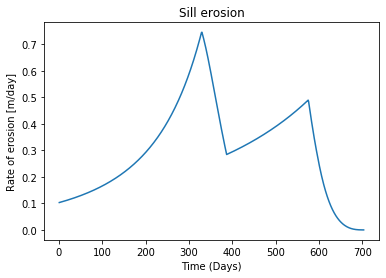

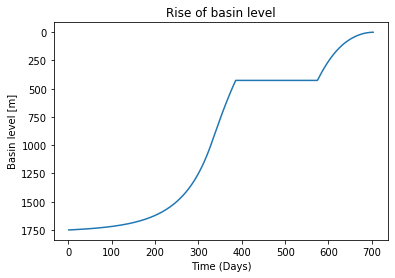

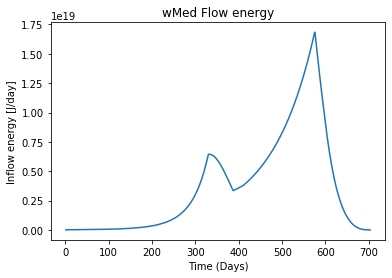

In [29]:
#Stage 1
while SL_wMed>430:
    
    if SL_wMed>1000:
   
        Slope = (1000 - Z0)/L      # Maximum headloss set to 1000 m for a conservative estimation
    
        [AreaSill, Rh, v_wMed, Q, Shear, Erate, Qd] = Calc_common_parameters(Wsill,Z0,DMar,g,D_sill,Slope,Kb,a)
        
        Hypsometrywmed = np.loadtxt(fname="Hypsometry_wMed_Refilling.txt")  # Upload wMed hypsometry
        
        KEwMed = 0.5*Q*v_wMed**2*1027*3600*24   # Flow kinetic energy entering the wMed
    
        # correct sea-level calculation (Hypsometry gives the sea-level to closest meter)
        # (Here true rise in sea-level is calculated using the error in volume calculation : see above diagram)
        Vbrine = Vbrine+Qd
        for i0,j0,k0 in Hypsometrywmed: # i0=depth, j0=area, k0=volume
            
            x0.append(k0)  # temporarily appends volume values
            y0.append(j0)  # temporarily appends area values

            if Vbrine<k0:
                z = z- ((Vbrine-x0[-2])/j0)

                x0=[]
                y0=[]
                break
            else:
                z=i0
    
        SL_wMed = z  # Daily sea-level
        
        Wsill = Kw*(Q**Aw)  # Sill width at Gibraltar 
                   

        D_sill = D_sill+(Erate/365)  # Daily sill depth evolution
        
        [Ar_SWd,Ar_t,Ar_VwM,Ar_dis,Ar_eR,Ar_SLw,Ar_KEw]=append_parameters(Wsill,t,v_wMed,Q,Erate,SL_wMed,KEwMed)
        
        t = t+1  # time
        
    elif SL_wMed<=1000:
   
        Slope = SL_wMed/L
     
        [AreaSill, Rh, v_wMed, Q, Shear, Erate, Qd] = Calc_common_parameters(Wsill,Z0,DMar,g,D_sill,Slope,Kb,a)
        Hypsometrywmed = np.loadtxt(fname="Hypsometry_wMed_Refilling.txt")
        
        KEwMed = 0.5*Q*v_wMed**2*1027*3600*24
    
        # correct sea-level calculation
        Vbrine = Vbrine+Qd
        for i0,j0,k0 in Hypsometrywmed: # i0=depth, j0=area, k0=volume
            
            x0.append(k0)
            y0.append(j0)
    
            if Vbrine<k0:
                z = z- ((Vbrine-x0[-2])/j0)
                x0=[]
                y0=[]
                break
            else:
                z=i0
    
        SL_wMed = z  # Daily sea-level
        
        Wsill = Wsill  # Sill width at Gibraltar
        
        D_sill = D_sill+(Erate/365) # Daily sill depth evolution
        
        [Ar_SWd,Ar_t,Ar_VwM,Ar_dis,Ar_eR,Ar_SLw,Ar_KEw]=append_parameters(Wsill,t,v_wMed,Q,Erate,SL_wMed,KEwMed)
 
        t = t+1
#Stage 2
while SL_eMed>430:

    Slope = SL_wMed/L
    
    [AreaSill, Rh, v_wMed, Q, Shear, Erate, Qd] = Calc_common_parameters(Wsill,Z0,DMar,g,D_sill,Slope,Kb,a)
    Hypsometryemed = np.loadtxt(fname="Hypsometry_eMed_Refilling.txt")
    
    KEwMed = 0.5*Q*v_wMed**2*1027*3600*24
    
    Vbrine2 = Vbrine2+Qd
    
    # correct sea-level calculation
    for i0,j0,k0 in Hypsometryemed: # i0=depth, j0=area, k0=volume
            
            x0.append(k0)
            y0.append(j0)
    
            if Vbrine2<k0:
                z = z- ((Vbrine2-x0[-2])/j0)
                x0=[]
                y0=[]
                break
            else:
                z=i0
    
    SL_eMed = z  # Daily sea-level

    Wsill2 = Kw*(Q**Aw)
    if Wsill2 < Wsill:
        Wsill2 = Wsill
    else:
        Wsill2 = Wsill2
        Wsill = Wsill2

    
    [Ar_SWd,Ar_t,Ar_VwM,Ar_dis,Ar_eR,Ar_SLw,Ar_KEw]=append_parameters(Wsill,t,v_wMed,Q,Erate,SL_wMed,KEwMed)

    D_sill = D_sill+(Erate/365)
    t = t+1
    
#Stage 3    
while SL_eMed<430:
    if SL_eMed>0:
        
        Slope = SL_wMed/L
        
        [AreaSill, Rh, v_wMed, Q, Shear, Erate, Qd] = Calc_common_parameters(Wsill,Z0,DMar,g,D_sill,Slope,Kb,a)
        HypsometryWholemed = np.loadtxt(fname="Hypsometry_Stage3_Refilling.txt")
        
        KEwMed = 0.5*Q*v_wMed**2*1027*3600*24
    
        Vbrine3 = Vbrine3+Qd
        # correct sea-level calculation
        for i0,jw,kw,je,ke,j0,k0 in HypsometryWholemed: # i0 = depth, jw = area wMed, kw = volume wMed, je = area eMed
                                                        # ke = volume eMed, j0/k0 = total area/volume above Sicily sill
            x0.append(k0)
            y0.append(j0)
    
            if Vbrine3<k0:
                z = z-((Vbrine3-x0[-2])/j0)
                x0=[]
                y0=[]
                break
            else:
                z=i0
    
        SL_wMed = z  # Daily sea-level
        SL_eMed = SL_wMed
        
        Wsill=Wsill
        [Ar_SWd,Ar_t,Ar_VwM,Ar_dis,Ar_eR,Ar_SLw,Ar_KEw]=append_parameters(Wsill,t,v_wMed,Q,Erate,SL_wMed,KEwMed)

        t = t+1

        if D_sill<240:
            D_sill = D_sill+(Erate/365) 
        else:
            D_sill = 240
            

    elif SL_wMed==0:
        break
 
    
    if SL_wMed<0.01:
        
        break
    
plt.figure()
plt.title('Sill width evolution')
plt.ylabel('Sill width [m]')
plt.xlabel('Time (Days)')
plt.plot(Ar_t[1:],Ar_SWd[1:])
plt.figure()
plt.title('wMed flow velocity')
plt.ylabel('Velocity [m/s]')
plt.xlabel('Time (Days)')
plt.plot(Ar_t[1:],Ar_VwM[1:])
plt.figure()
plt.title('Flow discharge')
plt.ylabel('Discharge [m^3/s]')
plt.xlabel('Time (Days)')
plt.plot(Ar_t[1:],Ar_dis[1:])
plt.figure()
plt.title('Sill erosion')
plt.ylabel('Rate of erosion [m/day]')
plt.xlabel('Time (Days)')
plt.plot(Ar_t[1:],Ar_eR[1:])
plt.figure()
plt.title('Rise of basin level')
plt.ylabel('Basin level [m]')
plt.xlabel('Time (Days)')
plt.plot(Ar_t[1:],Ar_SLw[1:])
plt.gca().invert_yaxis()
plt.figure()
plt.title('wMed Flow energy')
plt.ylabel('Inflow energy [J/day]')
plt.xlabel('Time (Days)')
plt.plot(Ar_t[1:],Ar_KEw[1:])

np.savetxt("wMed_flow_KE.txt", np.array(Ar_KEw), fmt="%s") 
np.savetxt("SL_rise_wMed.txt", np.array(Ar_SLw), fmt="%s") 
np.savetxt("Discharge.txt", np.array(Ar_dis), fmt="%s") 
np.savetxt("wMed_velocity.txt", np.array(Ar_VwM), fmt="%s") 

Ar_Sl_toSicily = Ar_SLw[0:387]  # Sea-level rise during stage 1
Ar_Sl_toSicily = np.array(Ar_Sl_toSicily)
np.savetxt("SLrise_toSicily.txt", np.array(Ar_Sl_toSicily), fmt="%s") 

Ar_SlriseStage3 = Ar_SLw[574:]  # Sea-level rise during stage 3
Ar_SlriseStage3 = np.array(Ar_SlriseStage3)
np.savetxt("SLrise_Stage3.txt", np.array(Ar_SlriseStage3), fmt="%s") 